## Dependencies

In [1]:
!pip install xgboost --upgrade

     |████████████████████████████████| 173.5 MB 71 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
!pip install shap

     |████████████████████████████████| 371 kB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509239 sha256=c7eff8753a77242bae94e4b455b05ffd07b94c29fcaa8282a352e83f8ad34fe4
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [3]:
!pip install linearmodels

     |████████████████████████████████| 1.5 MB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 26.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
import  pandas as pd,\
  google.colab as gcl,\
  xgboost as xgb,\
  sklearn.model_selection as slms,\
  shap as shp,\
  sklearn.metrics as slm,\
  numpy as np,\
  matplotlib.pyplot as pypl,\
  statsmodels.formula.api as smfa,\
  linearmodels.iv as lmiv,\
  statsmodels.api as sma,\
  seaborn as sns


In [5]:
pypl.style.use('bmh')

In [6]:
gcl.drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load Data

In [7]:
df_train_raw = pd.read_csv(
  './drive/MyDrive/2021/NUS_MSBA/DBA5106/5106: FBA Project/Housing Price Dataset/train.csv',
  header='infer',
  index_col=False
)


In [8]:
df_cost_matrix = df_train_raw[['SalePrice','2ndFlrSF']]

In [9]:
df_train_input = df_train_raw.drop(columns=['OverallCond','OverallQual','SalePrice',
'HouseStyle',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'MSSubClass',
'FullBath',
'HalfBath',
'GrLivArea'
] )

In [10]:
df_train_input['YrSold'] = df_train_input['YrSold'].astype('object')
df_train_input['MoSold'] = df_train_input['MoSold'].astype('object')
df_train_input['YearBuilt'] = df_train_input['YearBuilt'].astype('object')
df_train_input['YearRemodAdd'] = df_train_input['YearRemodAdd'].astype('object')
df_train_input['GarageYrBlt'] = df_train_input['GarageYrBlt'].astype('object')


In [11]:
df_train_input.dropna(subset=[ 'LotFrontage'] ,inplace=True)

In [12]:
categorical_columns = df_train_input.select_dtypes(include='object').columns.tolist()

df_train_dummies = pd.get_dummies(data=df_train_input,columns=categorical_columns)




In [14]:
df_cost_matrix['class_floor2'] = df_cost_matrix['2ndFlrSF'] > 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_cost_matrix.groupby(['class_floor2'])['SalePrice'].describe().transpose()

class_floor2,False,True
count,829.000000,631.000000
mean,171383.670688,193451.478605
std,73921.071585,84599.606596
min,34900.000000,37900.000000
25%,126500.000000,137225.000000
50%,150000.000000,177000.000000
75%,198900.000000,228500.000000
max,611657.000000,755000.000000


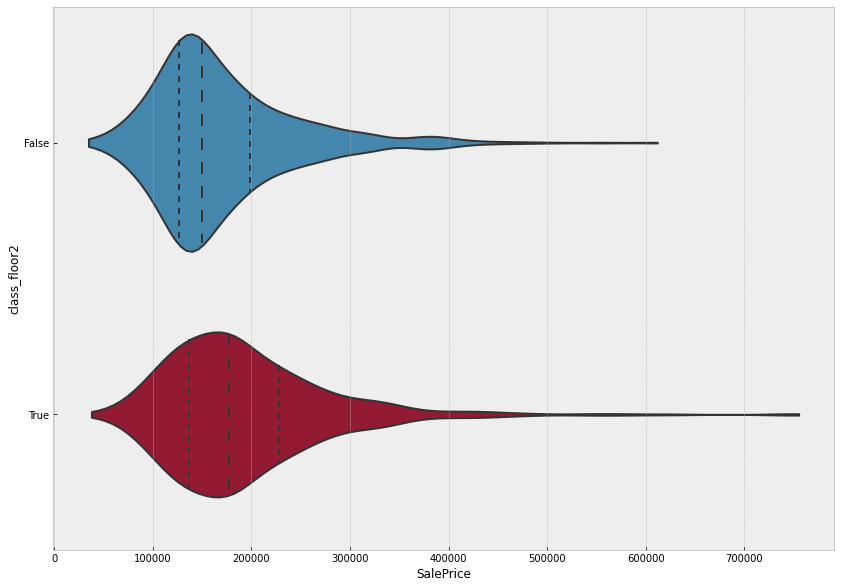

In [21]:
sns.violinplot(
  x='SalePrice',
  y='class_floor2',
  orient='h',
  data=df_cost_matrix,
  cut=0,
  inner='quartile'
)

pypl.gcf().set_size_inches(14, 10)

pypl.show()

pypl.close('all')

In [ ]:
(df_train_dummies['2ndFlrSF'] > 0).value_counts()

False    962
True     730
Name: 2ndFlrSF, dtype: int64

In [ ]:
print(730/(730+962))

0.4314420803782506


## Classification

In [ ]:
# Create classifier
df_train_dummies['class_floor2'] = df_train_dummies['2ndFlrSF'] > 0

In [ ]:
input_features =  df_train_dummies.columns.tolist()
input_features.remove('Id')
input_features.remove('class_floor2')
input_features.remove('2ndFlrSF')

In [ ]:
X_train, X_test, y_train, y_test = slms.train_test_split(
  df_train_dummies[input_features],
  df_train_dummies['class_floor2'],
  test_size=0.25 
)

In [ ]:
xgboost_classifier = xgb.XGBClassifier(n_jobs=4,verbosity=3)

In [ ]:
xgboost_classifier.fit(
  X_train, 
  y_train, 
#  early_stopping_rounds=10, 
  eval_metric="auc",
  eval_set=[(X_test, y_test)]
)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:02:19] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.84760
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.86688
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.88534
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.88528
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.88409
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.88550
[03:02:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=3)

## Profit curve

In [ ]:
y_proba = xgboost_classifier.predict_proba(X_test)[:,1]

In [ ]:
# Cell values corresponds to those in the confusion matrix [[tp, fp], [fn, tn]]

mean_secondstory_price = df_cost_matrix[df_cost_matrix['2ndFlrSF']>0 ]['SalePrice'].mean() - df_cost_matrix[df_cost_matrix['2ndFlrSF'] == 0 ]['SalePrice'].mean()  
mean_secondstory_size = df_cost_matrix[df_cost_matrix['2ndFlrSF']>0 ]['2ndFlrSF'].mean()
std_secondstory_price = df_cost_matrix[df_cost_matrix['2ndFlrSF']>0 ]['SalePrice'].std() - df_cost_matrix[df_cost_matrix['2ndFlrSF'] == 0 ]['SalePrice'].std()  

costbenefit_mat = np.array(
  [
    [  mean_secondstory_price
    , -300 *    mean_secondstory_size ], 
    [0,0]
  ]
)

In [ ]:
thresholds = sorted(y_proba, reverse=True)

profits = []

# For each threshold, calculate profit
for T in thresholds:
    y_pred_profit = (y_proba > T).astype(int) # predict label based on the cutoff thresholds
    [[tn, fp], [fn, tp]] = slm.confusion_matrix(y_test.astype('int'), y_pred_profit) # get the confusion matrix for each threshold
    confusion_mat = np.array([[tp, fp], [fn, tn]])
    # Calculate total profit (in the test data) for this threshold
    profit = sum(sum(confusion_mat * costbenefit_mat))
    profits.append(profit)

In [ ]:
# Profit curve plot
pypl.plot(np.linspace(0, 1, len(y_test)), profits)
pypl.xlabel('Test instances proportion (descending by score)')
pypl.ylabel('USD Profit')
pypl.title('Profit Curve - 2nd Story')

pypl.gcf().set_size_inches(14, 10)


#pypl.show()

pypl.savefig('./expected_value_floor2.png')

pypl.close('all')

In [ ]:
print("The optimal total profit of ", max(profits),"is obtained with threshold of", thresholds[np.argmax(profits)] )

The optimal total profit of  1549818.463878967 is obtained with threshold of 0.9708164


In [ ]:
mean_secondstory_price


22067.807917812897

In [ ]:
mean_secondstory_size

800.6997742663657

## Stochastic Matrix

In [ ]:
df_train_raw.drop(columns=['OverallCond',
'HouseStyle',
'BedroomAbvGr',
'KitchenAbvGr',
'TotRmsAbvGrd',
'MSSubClass',
'FullBath',
'HalfBath',
'GrLivArea'
], inplace=True )

In [ ]:
df_train_raw.dropna( subset=['SalePrice','LotFrontage'] ,inplace=True)

In [ ]:
df_train_raw['class_floor2'] = (df_train_raw['2ndFlrSF'] > 0).astype('int')

In [ ]:
df_iv =  sma.add_constant(df_train_raw,has_constant='add')

In [ ]:
features_iv = df_iv.columns.tolist()
features_iv.remove('SalePrice')
features_iv.remove('class_floor2')
features_iv.remove('LotArea')
features_iv.remove('OverallQual')
features_iv.remove('2ndFlrSF')

object_columns = df_iv.select_dtypes(include='object').columns.tolist()

In [ ]:
df_iv[object_columns] = df_iv[object_columns].astype('category')

In [ ]:
storey_2_iv = lmiv.IV2SLS.from_formula(
  data=df_iv,
  formula='SalePrice ~ SaleType + SaleCondition + YrSold ' \
  '+ TotalBsmtSF + LotFrontage + Fireplaces + BsmtFullBath ' \
  '+ GarageCars + WoodDeckSF + OpenPorchSF + Condition1 + YearBuilt + [class_floor2 ~ OverallQual + LotArea]'
 ).fit(cov_type='unadjusted')

In [ ]:
storey_2_iv

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              SalePrice   R-squared:                      0.2275
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2070
No. Observations:                1201   F-statistic:                    8494.2
Date:                Sun, Nov 21 2021   P-value (F-stat)                0.0000
Time:                        03:29:26   Distribution:                 chi2(32)
Cov. Estimator:            unadjusted                                         
                                                                              
                                    Parameter Estimates                                     
============================================================================================
                          Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------------
SaleType[COD]            -1.654e+06  3.277e+06    -0.5049     0.6137  -8.078e+06   4.769e+06
SaleType[CWD]            -1.604e+06  3.276e+06    -0.4897     0.6243  -8.025e+06   4.817e+06
SaleType[Con]            -1.629e+06  3.279e+06    -0.4968     0.6193  -8.055e+06   4.797e+06
SaleType[ConLD]          -1.634e+06  3.276e+06    -0.4986     0.6180  -8.055e+06   4.788e+06
SaleType[ConLI]          -1.658e+06  3.278e+06    -0.5060     0.6129  -8.083e+06   4.766e+06
SaleType[ConLw]          -1.639e+06  3.277e+06    -0.5002     0.6169  -8.062e+06   4.784e+06
SaleType[New]            -1.638e+06  3.275e+06    -0.5002     0.6170  -8.057e+06   4.781e+06
SaleType[Oth]            -1.627e+06  3.275e+06    -0.4968     0.6193  -8.046e+06   4.792e+06
SaleType[WD]             -1.646e+06  3.277e+06    -0.5024     0.6154  -8.068e+06   4.776e+06
SaleCondition[T.AdjLand]  2.514e+04  3.792e+04     0.6629     0.5074  -4.919e+04   9.947e+04
SaleCondition[T.Alloca]   4.844e+04   2.56e+04     1.8920     0.0585     -1738.8   9.861e+04
SaleCondition[T.Family]  -1.089e+04  1.954e+04    -0.5575     0.5772  -4.919e+04    2.74e+04
SaleCondition[T.Normal]      7640.7     9049.8     0.8443     0.3985   -1.01e+04   2.538e+04
SaleCondition[T.Partial]  2.973e+04  4.425e+04     0.6718     0.5017    -5.7e+04   1.165e+05
Condition1[T.Feedr]         2.3e+04  1.462e+04     1.5729     0.1157     -5659.9   5.166e+04
Condition1[T.Norm]        3.905e+04  1.176e+04     3.3203     0.0009     1.6e+04    6.21e+04
Condition1[T.PosA]        9.414e+04  3.967e+04     2.3727     0.0177   1.638e+04   1.719e+05
Condition1[T.PosN]       -2.372e+04  2.727e+04    -0.8700     0.3843  -7.716e+04   2.972e+04
Condition1[T.RRAe]        4.829e+04  2.812e+04     1.7171     0.0860     -6829.8   1.034e+05
Condition1[T.RRAn]        1.509e+04  1.878e+04     0.8035     0.4217  -2.172e+04    5.19e+04
Condition1[T.RRNe]       -2.486e+04  7.442e+04    -0.3341     0.7383  -1.707e+05    1.21e+05
Condition1[T.RRNn]        5.898e+04  3.865e+04     1.5258     0.1271  -1.678e+04   1.347e+05
YrSold                       173.46     1634.6     0.1061     0.9155     -3030.3      3377.3
TotalBsmtSF                  127.40     9.4220     13.522     0.0000      108.94      145.87
LotFrontage                  161.80     100.52     1.6095     0.1075     -35.229      358.82
Fireplaces                   1850.8     4338.1     0.4266     0.6696     -6651.6   1.035e+04
BsmtFullBath              2.793e+04     4738.7     5.8943     0.0000   1.864e+04   3.722e+04
GarageCars                1.179e+04     3993.0     2.9519     0.0032      3960.9   1.961e+04
WoodDeckSF                   15.156     19.623     0.7724     0.4399     -23.304      53.616
OpenPorchSF                 -126.10     39.689    -3.1773     0.0015     -203.89     -48.314
YearBuilt                    600.31     92.069     6.5202     0.0000      419.86      780.76
class_floor2              1.703e+05  1.443e+04     11.796   

In [ ]:
storey_2_iv.wooldridge_regression


Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 325.0579
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7ff0b97af050

In [ ]:
storey_2_iv.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 316.6404
P-value: 0.0000
Distributed: F(1,1168)
WaldTestStatistic, id: 0x7ff0b973e350

In [ ]:
scenarios = []
list_x_axis = np.linspace(0, 1, len(y_test)).tolist()

for scenario_mean in np.random.normal( loc = 170300, scale= 14430, size =5).tolist():

  thresholds = sorted(y_proba, reverse=True)

  profits = []

  # For each threshold, calculate profit
  for T in thresholds:
      y_pred_profit = (y_proba > T).astype(int) # predict label based on the cutoff thresholds
      [[tn, fp], [fn, tp]] = slm.confusion_matrix(y_test.astype('int'), y_pred_profit) # get the confusion matrix for each threshold
      confusion_mat = np.array([[tp, fp], [fn, tn]])
      # Calculate total profit (in the test data) for this threshold
      
  
      costbenefit_mat[0][0] = scenario_mean
      
      
      profit = sum(sum(confusion_mat * costbenefit_mat))
      profits.append(profit)
  output = [{ 'threshold': list_x_axis[i], 'scenario_mean': scenario_mean, 'profit':profits[i] } for i in range(len(y_test))]
  
  
  scenarios = output + scenarios

In [ ]:
df_plot = pd.DataFrame(scenarios)

sns.lineplot(
  x='threshold',
  y='profit',
  hue='scenario_mean',
  data= df_plot
)

pypl.xlabel('Test instances proportion (descending by score)')
pypl.ylabel('USD Profit')
pypl.title('Profit Curve, By 2SLS Mean - 2nd Storey')

pypl.gcf().set_size_inches(14, 10)

pypl.savefig('./stochastic_expected_value_floor2.png')

#pypl.show()

pypl.close('all')

In [ ]:
#df_plot.groupby(['scenario_mean'])['profit'].max().reset_index()

df_plot.pivot_table(
  index='scenario_mean',
  values='profit',
  aggfunc=[np.max,np.min]
)

,amax,amin
,profit,profit
scenario_mean,,
168694.971966,1.833816e+07,-2.940133e+07
179213.640473,1.991596e+07,-2.755004e+07
184952.814096,2.077683e+07,-2.653995e+07
190561.320548,2.161811e+07,-2.555285e+07
195685.912559,2.238680e+07,-2.465092e+07


## Explainability

In [ ]:
explainer = shp.TreeExplainer(xgboost_classifier)

shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


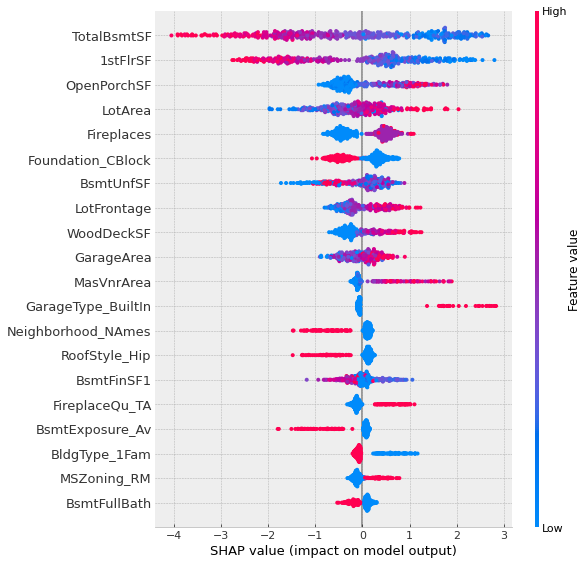

In [ ]:
shp.summary_plot(shap_values,X_test)